Idea: Validate a prediction at a certain position against the robot measurement.

In [1]:
from data.hrmcampaign import HRMCampaignDataset
from data.hrm import HRMDataset

#dataset = HRMDataset("data/hrm", radius=0.3)
dataset_campaign = HRMCampaignDataset("data/hrmcampaign", radius=0.3)

In [7]:
CKPT_PTH = "models/saved_models/feb_version_3/checkpoints/epoch=4-step=2475.ckpt"
SAVE_PLOTS = True

import torch
from models.rabignn import PLModule

torch.manual_seed(1337)
# Load actual model
model = PLModule.load_from_checkpoint(CKPT_PTH)
model = model.to('cpu')
model.eval()

PLModule(
  (model): GNN(
    (dropout): Dropout(p=0.25, inplace=False)
    (embedding_layer): Linear(20, 5, bias=True)
    (first_layer): GATv2Conv(15, 50, heads=4)
    (inner_layers): ModuleList(
      (0-2): 3 x GATv2Conv(205, 50, heads=4)
    )
    (last_layer): GATv2Conv(205, 10, heads=1)
  )
  (loss_mse): MSELoss()
)

## Without upscaling

### Single example

In [8]:
import torch.nn.functional as F

data = dataset_campaign[99]

# create robot_mask 
robot_mask = (data.id == 0).repeat(10,1).T & ~torch.isnan(data.y)
data.y[robot_mask]

# set robot measurements to 0 and unknown
data.x[data.id==0] = 0
data.known[data.id==0] = False

pred = model(data)

F.mse_loss(pred[robot_mask], data.y[robot_mask])

tensor(0.1912, grad_fn=<MseLossBackward0>)

<Axes: >

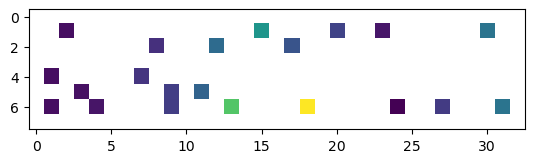

In [9]:
from utils.mapping import visualize_feature_as_image
CELL_SIZE = 5

visualize_feature_as_image(torch.nanmean(pred, dim=1).detach().numpy(), data.orig_pos, cell_size=CELL_SIZE)

In [12]:
data.y.shape

torch.Size([25, 10])

<Axes: >

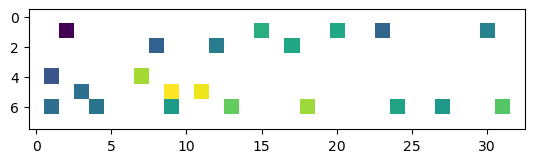

In [10]:
visualize_feature_as_image(torch.nanmean(data.y, dim=1), data.orig_pos, cell_size=CELL_SIZE)

### Whole dataset

In [8]:
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

dataloader = DataLoader(dataset_campaign, batch_size=1)

mse = 0

for data in tqdm(dataloader):
    # create robot_mask to select actual robot_measurements
    robot_mask = (data.id == 0).repeat(10,1).T & ~torch.isnan(data.y)

    # set all robot measurements to 0 and unknown
    data.x[data.id==0] = 0
    data.known[data.id==0] = False

    pred = model(data)

    mse += F.mse_loss(pred[robot_mask], data.y[robot_mask])

mse_avg = mse/len(dataloader)

print(f"Averaged MSE = {mse_avg}")

100%|██████████| 811/811 [00:24<00:00, 33.10it/s] 

Averaged MSE = 0.8971796035766602


## With Upscaling

### Single example

In [94]:
def create_robot_mask(data, upscaled_data):
    """
    For upscaled_data
    """
    robot_mask = torch.zeros(len(upscaled_data.orig_pos), dtype=torch.bool)
    robot_pos = data.orig_pos[data.id==0]
    # Assuming data.orig_pos correctly aligns with data.y
    for pos in robot_pos:
        # Find matches in upscaled_data.orig_pos
        pos = torch.round(pos/CELL_SIZE).int() * CELL_SIZE
        matches = (upscaled_data.orig_pos == pos).all(dim=1)
        robot_mask = robot_mask | matches
    return robot_mask

In [116]:
from utils.virtual import add_virtual_nodes
import torch.nn.functional as F

data = dataset_campaign[99]
upscaled_data = add_virtual_nodes(data, cell_size=CELL_SIZE, x_range=[0,152], y_range=[0,30])

# create robot_mask
robot_mask = create_robot_mask(data, upscaled_data)
temporal_robot_mask = upscaled_data.known[robot_mask]

# find true robot measurements
robot_y = upscaled_data.x[robot_mask][temporal_robot_mask]

# set robot measurements to 0 and unknown
upscaled_data.x[robot_mask] = 0 
upscaled_data.known[robot_mask] = False

pred = model(upscaled_data)
F.mse_loss(pred[robot_mask][temporal_robot_mask], robot_y)

tensor(0.2568, grad_fn=<MseLossBackward0>)

<Axes: >

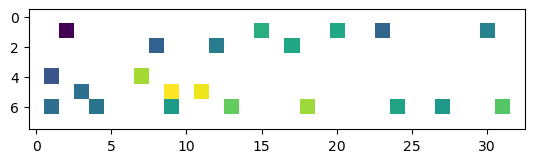

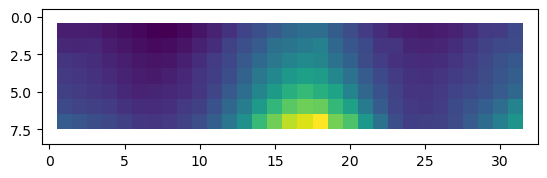

In [120]:
from utils.mapping import visualize_feature_as_image

CELL_SIZE = 5
visualize_feature_as_image(torch.nanmean(data.x, dim=1).detach().numpy(), data.orig_pos, cell_size=CELL_SIZE)
visualize_feature_as_image(torch.nanmean(pred, dim=1).detach().numpy(), upscaled_data.orig_pos, cell_size=CELL_SIZE)

### Whole Dataset

In [147]:
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

dataloader = DataLoader(dataset_campaign, batch_size=1)

mse = 0

for data in tqdm(dataloader):
    with torch.no_grad():
        upscaled_data = add_virtual_nodes(data, cell_size=CELL_SIZE, x_range=[0,160], y_range=[0,30])

        # create robot_mask
        robot_mask = create_robot_mask(data, upscaled_data)
        temporal_robot_mask = upscaled_data.known[robot_mask]

        # find true robot measurements
        robot_y = upscaled_data.x[robot_mask][temporal_robot_mask]

        # set robot measurements to 0 and unknown
        upscaled_data.x[robot_mask] = 0 
        upscaled_data.known[robot_mask] = False

        pred = model(upscaled_data)
        mse += F.mse_loss(pred[robot_mask][temporal_robot_mask], robot_y)
        if torch.isnan(mse):
            print("oh no")

mse_avg = mse/len(dataloader)

print(f"Averaged MSE = {mse_avg}")

100%|██████████| 811/811 [00:43<00:00, 18.61it/s]

Averaged MSE = 0.8461891412734985


In [144]:
torch.round(robot_pos/CELL_SIZE).int() * CELL_SIZE

tensor([[160,  15]], dtype=torch.int32)